In [2201]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import datasets

In [2202]:
df_train = pd.read_csv('train_Insurance.csv')
df_test = pd.read_csv('test_Insurance.csv')

df_train.head()

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,NumberOfWindows,Geo_Code,Claim
0,H13501,2012,1.0,1,N,V,V,U,1240.0,Wood-framed,without,75117,non
1,H14962,2012,1.0,0,N,V,V,U,900.0,Non-combustible,without,62916,non
2,H17755,2013,1.0,1,V,N,O,R,4984.0,Non-combustible,4,31149,oui
3,H13369,2016,0.5,0,N,V,V,U,600.0,Wood-framed,without,6012,oui
4,H12988,2012,1.0,0,N,V,V,U,900.0,Non-combustible,without,57631,non


In [2203]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5012 entries, 0 to 5011
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer Id         5012 non-null   object 
 1   YearOfObservation   5012 non-null   int64  
 2   Insured_Period      5012 non-null   float64
 3   Residential         5012 non-null   int64  
 4   Building_Painted    5012 non-null   object 
 5   Building_Fenced     5012 non-null   object 
 6   Garden              5008 non-null   object 
 7   Settlement          5012 non-null   object 
 8   Building Dimension  4935 non-null   float64
 9   Building_Type       5012 non-null   object 
 10  NumberOfWindows     5012 non-null   object 
 11  Geo_Code            4939 non-null   object 
 12  Claim               5012 non-null   object 
dtypes: float64(2), int64(2), object(9)
memory usage: 509.2+ KB


In [2204]:
df_train.describe(include='all')

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,NumberOfWindows,Geo_Code,Claim
count,5012,5012.000000,5012.000000,5012.000000,5012,5012,5008,5012,4935.000000,5012,5012,4939,5012
unique,5012,NaN,NaN,NaN,2,2,2,2,NaN,4,11,1115,2
top,H18228,NaN,NaN,NaN,V,N,O,R,NaN,Non-combustible,without,6088,non
freq,1,NaN,NaN,NaN,3763,2535,2532,2537,NaN,2310,2476,102,3886
mean,NaN,2013.660215,0.869713,0.301077,NaN,NaN,NaN,NaN,1876.898683,NaN,NaN,NaN,NaN
std,NaN,1.383134,0.219496,0.458772,NaN,NaN,NaN,NaN,2267.277397,NaN,NaN,NaN,NaN
min,NaN,2012.000000,0.500000,0.000000,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN
25%,NaN,2012.000000,0.500000,0.000000,NaN,NaN,NaN,NaN,520.000000,NaN,NaN,NaN,NaN
50%,NaN,2013.000000,1.000000,0.000000,NaN,NaN,NaN,NaN,1067.000000,NaN,NaN,NaN,NaN
75%,NaN,2015.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,2280.000000,NaN,NaN,NaN,NaN


In [2205]:
# Vérification des valeurs manquantes
df_train.isnull().sum()

Customer Id            0
YearOfObservation      0
Insured_Period         0
Residential            0
Building_Painted       0
Building_Fenced        0
Garden                 4
Settlement             0
Building Dimension    77
Building_Type          0
NumberOfWindows        0
Geo_Code              73
Claim                  0
dtype: int64

In [2206]:
from sklearn.impute import SimpleImputer
def Traitement_data(data):
    data.drop_duplicates(inplace=True,ignore_index=True)
    
    #fill Nan Values
    mostFrequentImputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    medianImputer = SimpleImputer(missing_values=np.nan , strategy='median')
    data[['Garden']]=mostFrequentImputer.fit_transform(data.loc[:,['Garden']])
    data[['Building Dimension']] = medianImputer.fit_transform(data[['Building Dimension']])
    data["NumberOfWindows"].replace({"without": 0, ">=10": 10}, inplace=True)
    # Filtrer les valeurs aberrantes
    Q1,Q3=np.percentile(data["Building Dimension"],[25,75])
    IQR=Q3-Q1
    upper_limit=Q3+1.5*IQR
    lower_limit=Q1-1.5*IQR

    data['Building Dimension']=np.where(data['Building Dimension']>upper_limit,upper_limit, 
                                        np.where(data['Building Dimension']<lower_limit, 
                                        lower_limit,data['Building Dimension']))
    return data

In [2207]:
from sklearn.preprocessing import RobustScaler, QuantileTransformer

def Transformation_data(data):
    # Transformation des données
    data = pd.get_dummies(
        data,
        columns=["Building_Painted", "Building_Fenced", "Garden", "Settlement"],
        dtype="int32",
    )
    data = pd.get_dummies(
        data, columns=["Building_Type"], dtype="int32", prefix="", prefix_sep=""
    )
    robust_scaler = RobustScaler()
    data[["Building Dimension"]] = robust_scaler.fit_transform(
        data[["Building Dimension"]]
    )

    transformer = QuantileTransformer(output_distribution="uniform")
    data[["YearOfObservation"]] = transformer.fit_transform(data[["YearOfObservation"]])

    return data

In [2208]:
def drop_columns(data):
    data.drop(["Geo_Code", "Customer Id", "NumberOfWindows"], axis=1, inplace=True)
    
    numeric_data = data.select_dtypes(include=[np.number])
    corr_matrix = numeric_data.corr().abs()

    # Seuil de corrélation
    threshold = 0.8

    # 1. Identifier les paires de variables fortement corrélées
    high_corr_pairs = np.where(corr_matrix > threshold)
    high_corr_pairs = [
        (corr_matrix.index[x], corr_matrix.columns[y])
        for x, y in zip(*high_corr_pairs)
        if x != y and x < y
    ]

    print("Paires fortement corrélées :", high_corr_pairs)

    # 2. Suppression des colonnes fortement corrélées
    features_to_drop = set()
    for pair in high_corr_pairs:
        features_to_drop.add(pair[1])  # Ajouter la colonne à éliminer

    df_reduced = data.drop(columns=features_to_drop)

    print("Features à éliminer:", features_to_drop)
    print("DataFrame réduite:\n", df_reduced)

    # Déplacer la colonne 'Claim' à la fin
    col_order = [col for col in df_reduced.columns if col != "Claim"] + ["Claim"]
    data = df_reduced[col_order]
    return data

In [2209]:
def distribution(data, x, bins=3):
    plt.Figure(figsize=(10, 5))
    sns.histplot( x=x, data=data ,bins=bins, kde=True, stat='density')
    plt.show()

In [2210]:
def matrice_correlation(data):
    numeric_data = data.corr(numeric_only=True)
    fig = plt.figure(figsize=(25, 20))
    sns.heatmap(numeric_data, annot=True, fmt=".3f", vmin=-1, vmax=1)
    plt.show()

In [2211]:
from scipy.stats import chi2_contingency


def chi(data, x, visualize=True):
    # Visualise the distribution of claims across Geo_Code
    if visualize:
        sns.countplot(data=data, x=x, hue="Claim")
        plt.xticks(rotation=90)
        plt.title("Claim Distribution Across {}".format(x))
        plt.show()

    # Create a contingency table
    contingency_table = pd.crosstab(data[x], data["Claim"])

    # Perform Chi-Square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"Chi-Square Statistic: {chi2}")
    print(f"P-value: {p}")

    # Interpretation
    if p < 0.05:
        print("There is a significant relationship between {} and Claim.".format(x))
    else:
        print("There is no significant relationship between {} and Claim.".format(x))

In [2212]:
df_train = Traitement_data(df_train)

/tmp/ipykernel_12235/942102811.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["NumberOfWindows"].replace({"without": 0, ">=10": 10}, inplace=True)


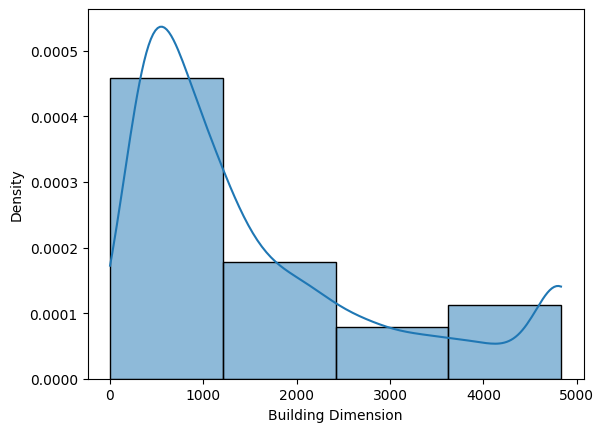

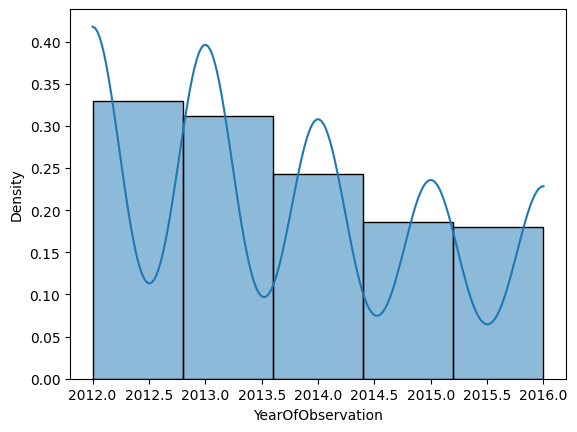

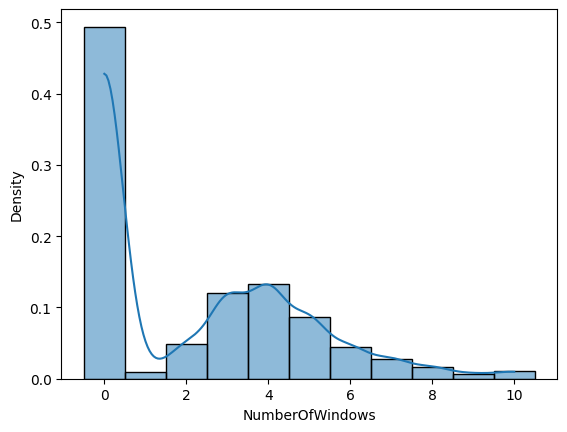

In [2213]:
distribution(df_train, 'Building Dimension', bins=4)
distribution(df_train, 'YearOfObservation', bins=5)
distribution(df_train, 'NumberOfWindows')

In [2214]:
df_train = Transformation_data(df_train)

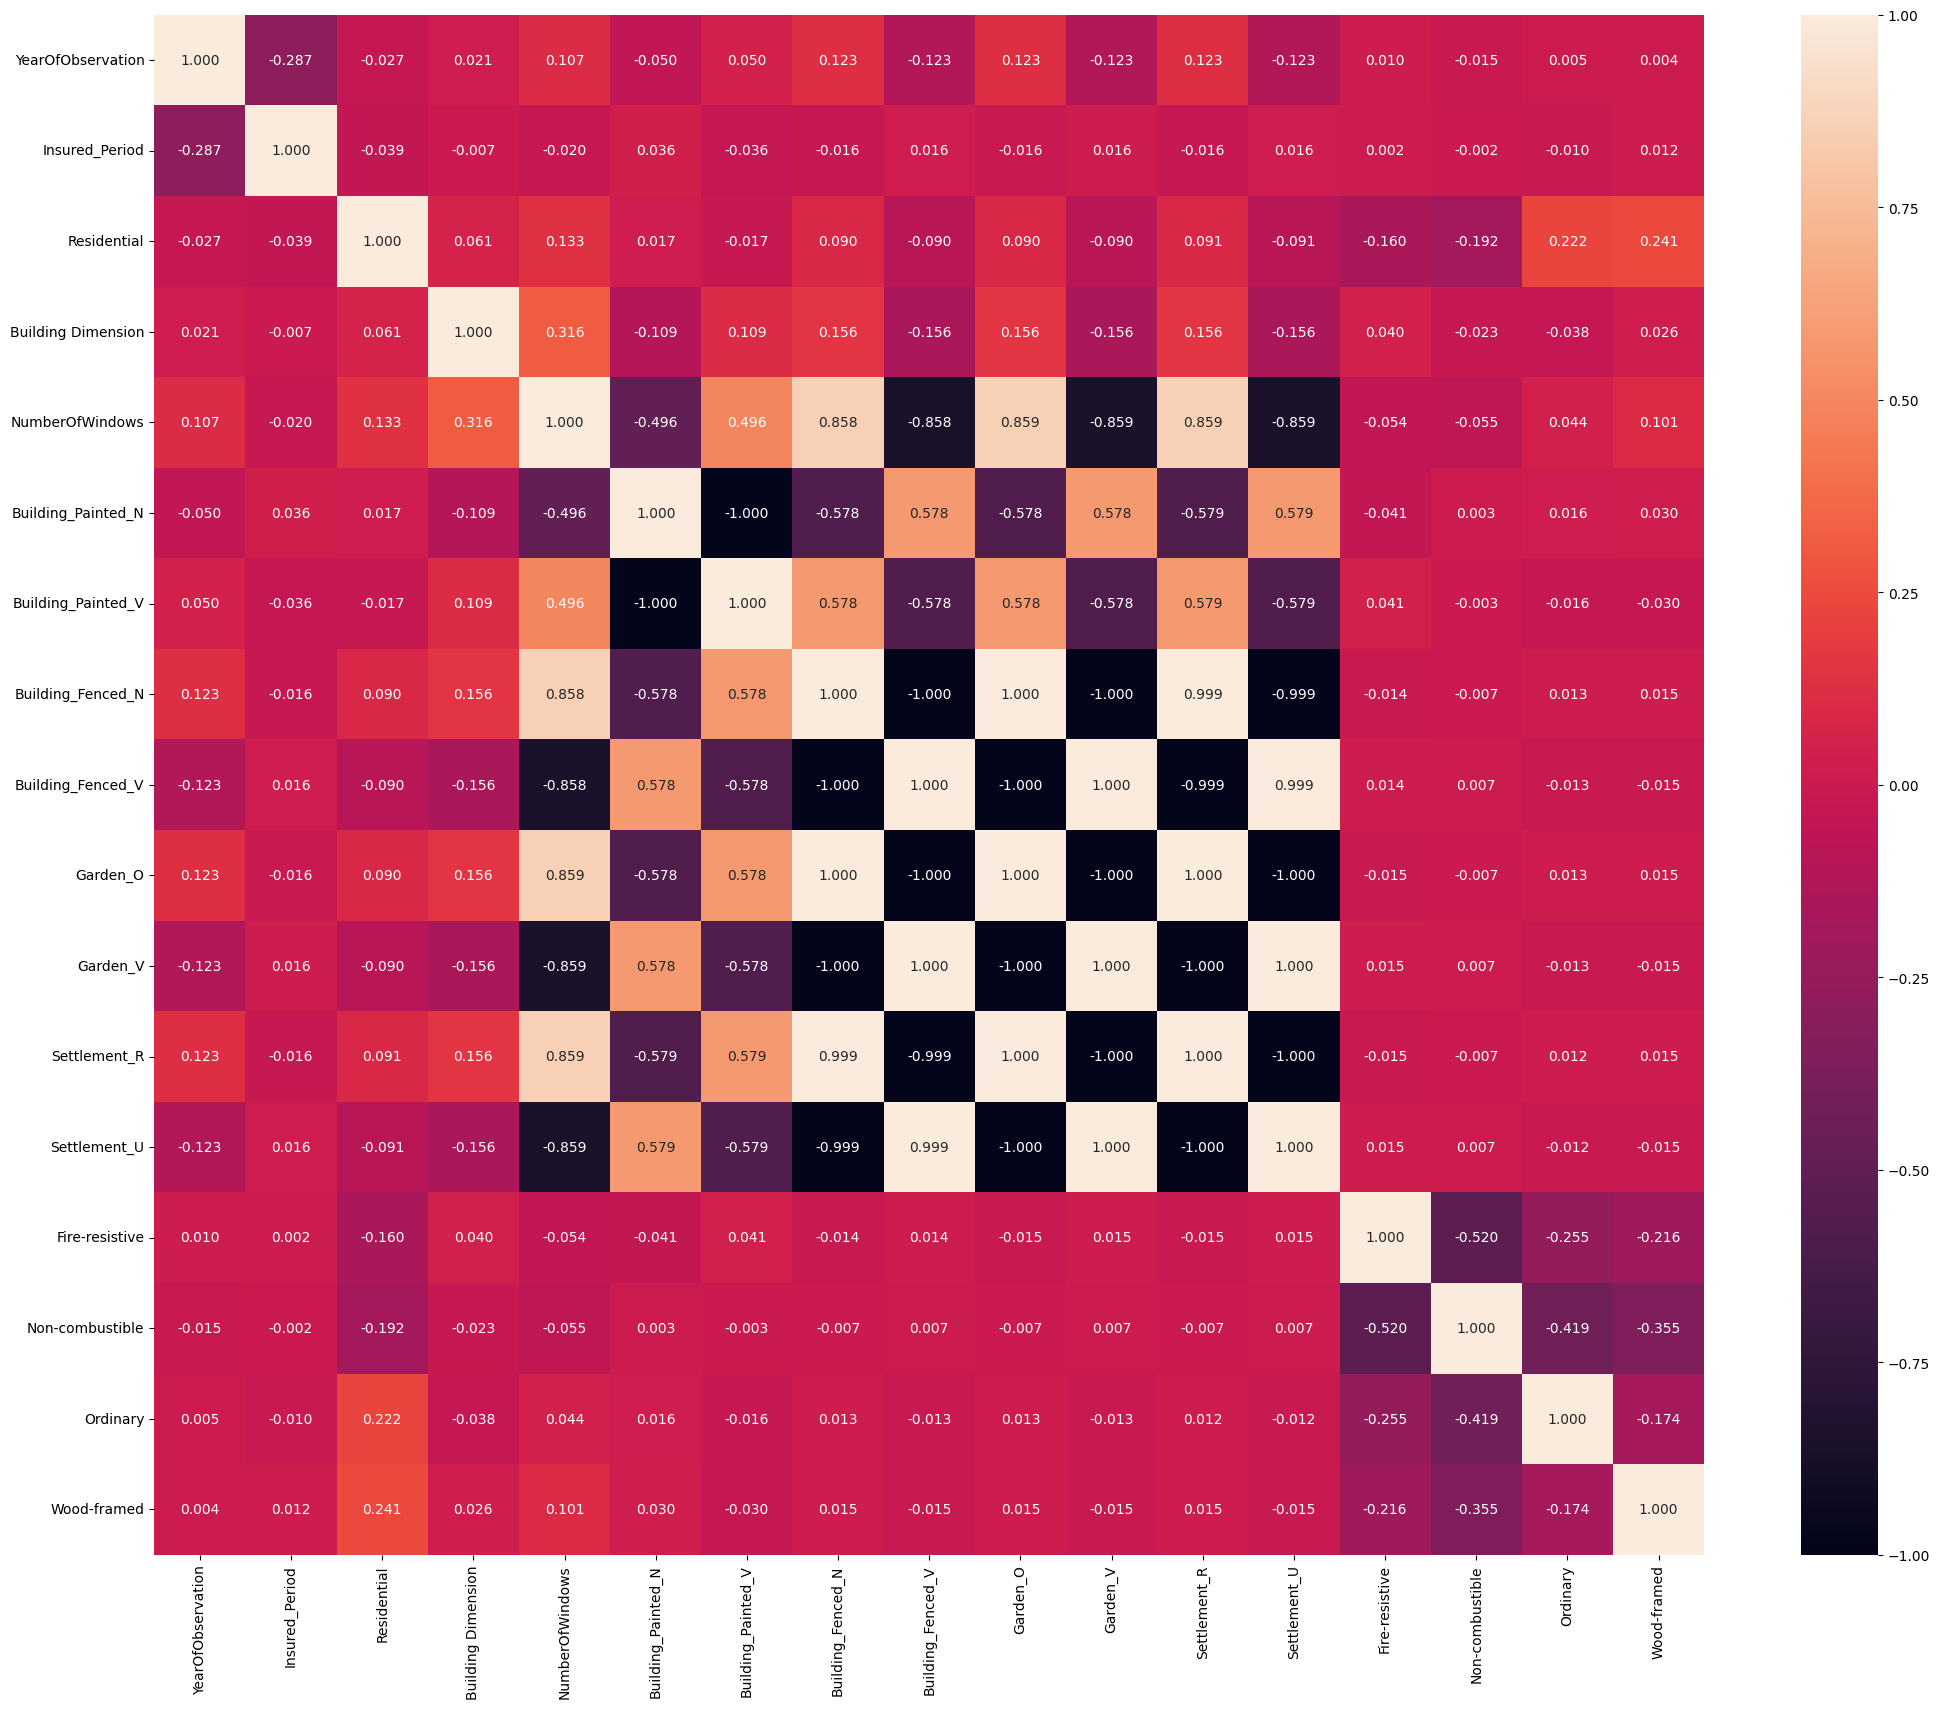

In [2215]:
df_train['NumberOfWindows'] = df_train['NumberOfWindows'].astype('int32')
matrice_correlation(df_train)

In [2216]:
chi(df_train, "Geo_Code", visualize=False)

Chi-Square Statistic: 1135.1518819057585
P-value: 0.3229684456666149
There is no significant relationship between Geo_Code and Claim.


In [2217]:
df_train = drop_columns(df_train)
df_train.head()

Paires fortement corrélées : [('Building_Painted_N', 'Building_Painted_V'), ('Building_Fenced_N', 'Building_Fenced_V'), ('Building_Fenced_N', 'Garden_O'), ('Building_Fenced_N', 'Garden_V'), ('Building_Fenced_N', 'Settlement_R'), ('Building_Fenced_N', 'Settlement_U'), ('Building_Fenced_V', 'Garden_O'), ('Building_Fenced_V', 'Garden_V'), ('Building_Fenced_V', 'Settlement_R'), ('Building_Fenced_V', 'Settlement_U'), ('Garden_O', 'Garden_V'), ('Garden_O', 'Settlement_R'), ('Garden_O', 'Settlement_U'), ('Garden_V', 'Settlement_R'), ('Garden_V', 'Settlement_U'), ('Settlement_R', 'Settlement_U')]
Features à éliminer: {'Settlement_R', 'Building_Fenced_V', 'Building_Painted_V', 'Garden_O', 'Settlement_U', 'Garden_V'}
DataFrame réduite:
       YearOfObservation  Insured_Period  Residential  Building Dimension  \
0              0.000000             1.0            1            0.100581   
1              0.000000             1.0            0           -0.097093   
2              0.388388            

,YearOfObservation,Insured_Period,Residential,Building Dimension,Building_Painted_N,Building_Fenced_N,Fire-resistive,Non-combustible,Ordinary,Wood-framed,Claim
0,0.000000,1.0,1,0.100581,1,0,0,0,0,1,non
1,0.000000,1.0,0,-0.097093,1,0,0,1,0,0,non
2,0.388388,1.0,1,2.187791,0,1,0,1,0,0,oui
3,1.000000,0.5,0,-0.271512,1,0,0,0,0,1,oui
4,0.000000,1.0,0,-0.097093,1,0,0,1,0,0,non


## Prétraitement des données de Test

In [2218]:
df_test = Traitement_data(df_test)
df_test = Transformation_data(df_test)
df_test = drop_columns(df_test)
df_test.head()

Paires fortement corrélées : [('Building_Painted_N', 'Building_Painted_V'), ('Building_Fenced_N', 'Building_Fenced_V'), ('Building_Fenced_N', 'Garden_O'), ('Building_Fenced_N', 'Garden_V'), ('Building_Fenced_N', 'Settlement_R'), ('Building_Fenced_N', 'Settlement_U'), ('Building_Fenced_V', 'Garden_O'), ('Building_Fenced_V', 'Garden_V'), ('Building_Fenced_V', 'Settlement_R'), ('Building_Fenced_V', 'Settlement_U'), ('Garden_O', 'Garden_V'), ('Garden_O', 'Settlement_R'), ('Garden_O', 'Settlement_U'), ('Garden_V', 'Settlement_R'), ('Garden_V', 'Settlement_U'), ('Settlement_R', 'Settlement_U')]
Features à éliminer: {'Settlement_R', 'Building_Fenced_V', 'Building_Painted_V', 'Garden_O', 'Settlement_U', 'Garden_V'}
DataFrame réduite:
       YearOfObservation  Insured_Period  Residential  Building Dimension  \
0              0.380881             1.0            0            1.535354   
1              0.773774             1.0            0            0.203175   
2              0.380881            

/tmp/ipykernel_12235/942102811.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["NumberOfWindows"].replace({"without": 0, ">=10": 10}, inplace=True)


,YearOfObservation,Insured_Period,Residential,Building Dimension,Building_Painted_N,Building_Fenced_N,Fire-resistive,Non-combustible,Ordinary,Wood-framed,Claim
0,0.380881,1.0,0,1.535354,0,0,1,0,0,0,oui
1,0.773774,1.0,0,0.203175,0,1,1,0,0,0,non
2,0.380881,1.0,1,0.487157,0,1,0,0,1,0,oui
3,0.773774,1.0,0,0.675325,1,0,0,1,0,0,oui
4,1.000000,0.5,0,1.082828,0,1,1,0,0,0,non


## Différentes modéles de Machine Learning

In [2219]:
# Séparation des données en variables explicatives et variable cible
X_train = df_train.drop("Claim", axis=1)
y_train = df_train["Claim"]

X_test = df_test.drop("Claim", axis=1)
y_test = df_test["Claim"]

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (5012, 10)
y_train shape: (5012,)
X_test shape: (2147, 10)
y_test shape: (2147,)


In [2220]:
# Modélisation avec un arbre de décision
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state=40, max_depth=9, max_features='sqrt')
dtc.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=9, max_features='sqrt', random_state=40)

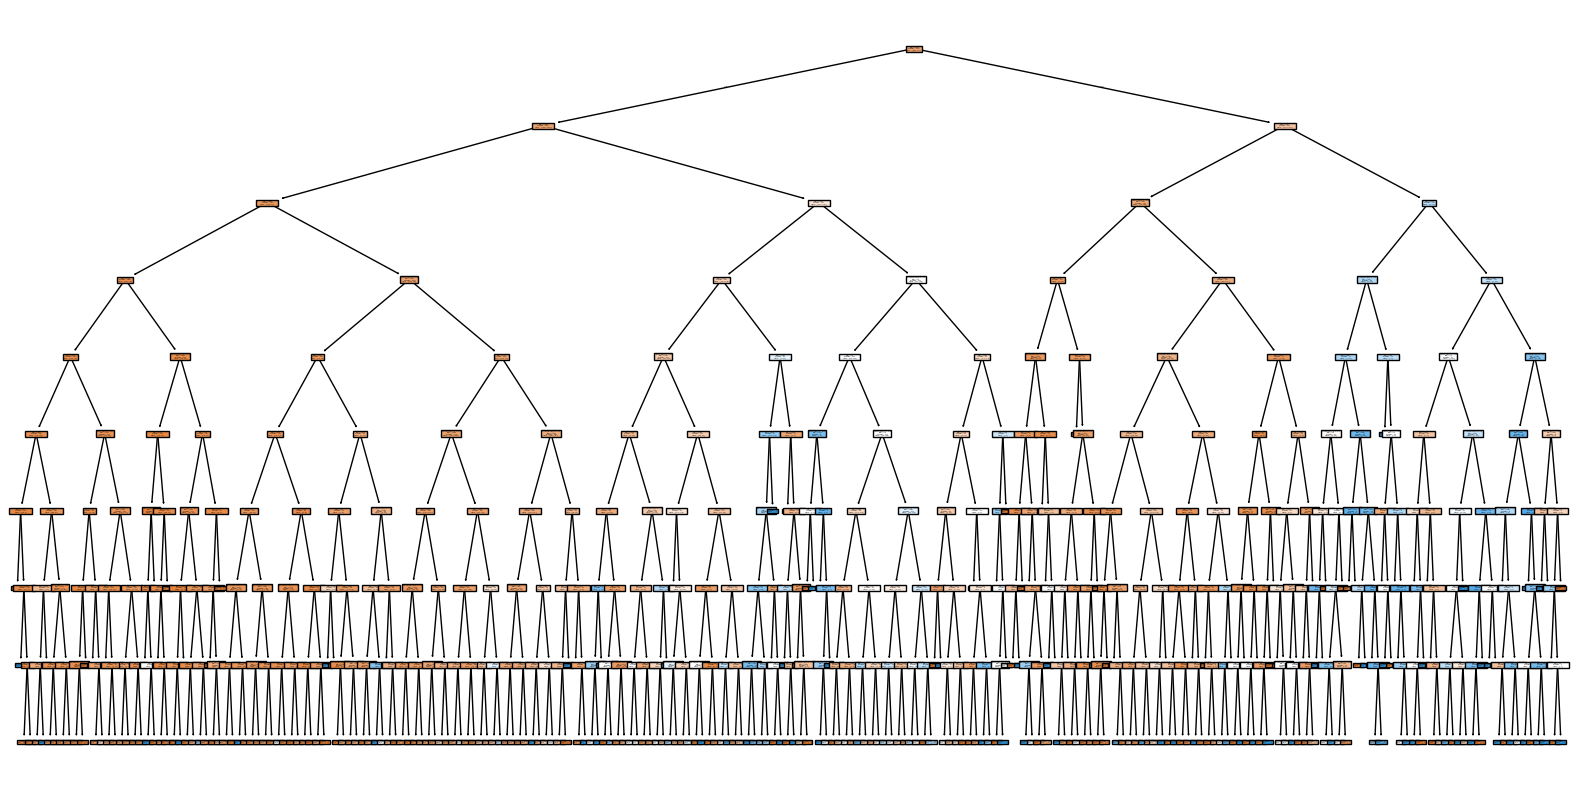

In [2221]:
# Visualisation de l'arbre
from sklearn.tree import plot_tree
plt.figure(figsize=(20, 10))
plot_tree(dtc, feature_names=X_train.columns, filled=True)
plt.show()

In [2222]:
from sklearn.metrics import accuracy_score, f1_score
def scores(model, X_train, y_train, X_test, y_test):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    print("Train Accuracy:", np.round(accuracy_score(y_train, y_pred_train), 2))
    print("Test Accuracy:", np.round(accuracy_score(y_test, y_pred_test), 2))

    print("F1 Train Score:", np.round(f1_score(y_train, y_pred_train, average='weighted'), 2))
    print("F1 Test Score:", np.round(f1_score(y_test, y_pred_test, average='weighted'), 2))

In [2223]:
scores(dtc, X_train, y_train, X_test, y_test)

Train Accuracy: 0.82
Test Accuracy: 0.76
F1 Train Score: 0.79
F1 Test Score: 0.72


In [2224]:
# Modélisation avec un Random Forest
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=40, n_estimators=100, max_depth=9, max_features='sqrt')
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=9, random_state=40)

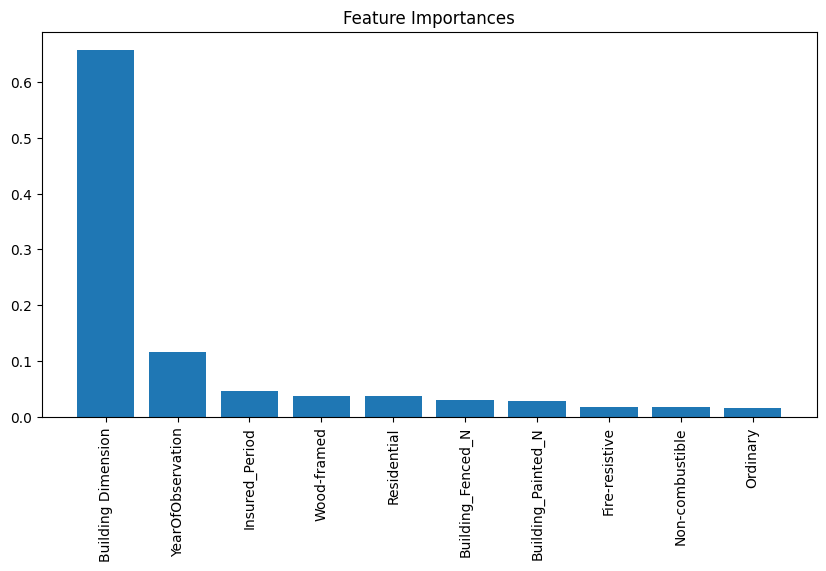

In [2225]:
# Visualisation de random forest
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 5))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.show()

In [2226]:
# Scores de Random Forest
scores(rfc, X_train, y_train, X_test, y_test)

Train Accuracy: 0.83
Test Accuracy: 0.76
F1 Train Score: 0.8
F1 Test Score: 0.71


In [2227]:
# Modélisation avec un SVC
from sklearn.svm import SVC
svc = SVC(random_state=40, kernel='linear')
svc.fit(X_train, y_train)

SVC(kernel='linear', random_state=40)

In [2228]:
# Scores de SVC
scores(svc, X_train, y_train, X_test, y_test)

Train Accuracy: 0.78
Test Accuracy: 0.76
F1 Train Score: 0.68
F1 Test Score: 0.66


In [2229]:
# Modélisation avec un Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(random_state=40, n_estimators=100, max_depth=9, max_features='sqrt')
gbc.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=9, max_features='sqrt', random_state=40)

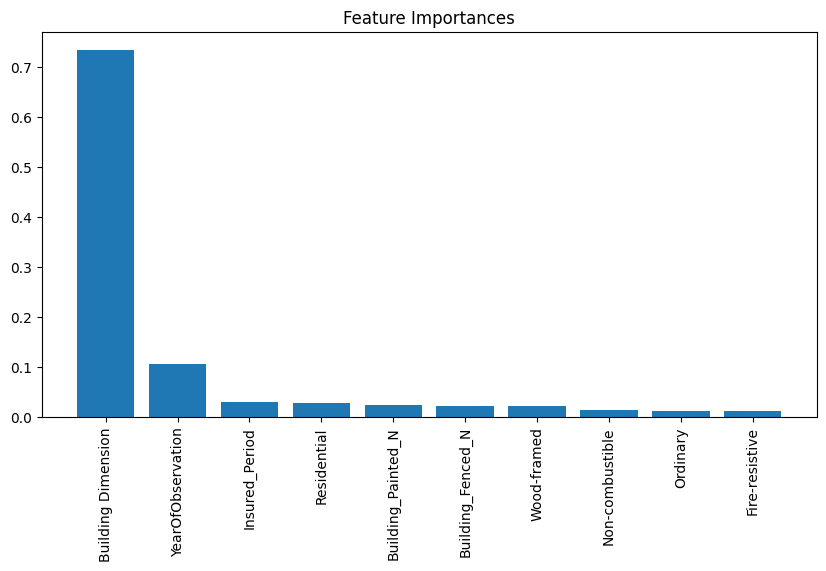

In [2230]:
# Visualisation de Gradient Boosting
importances = gbc.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 5))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.show()


In [2231]:
# Scores de Gradient Boosting
scores(gbc, X_train, y_train, X_test, y_test)

Train Accuracy: 0.93
Test Accuracy: 0.73
F1 Train Score: 0.93
F1 Test Score: 0.71


In [2232]:
# Modélisation avec un MLPClassifier
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(random_state=40, hidden_layer_sizes=(100, 50), max_iter=1000)
mlp.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=40)

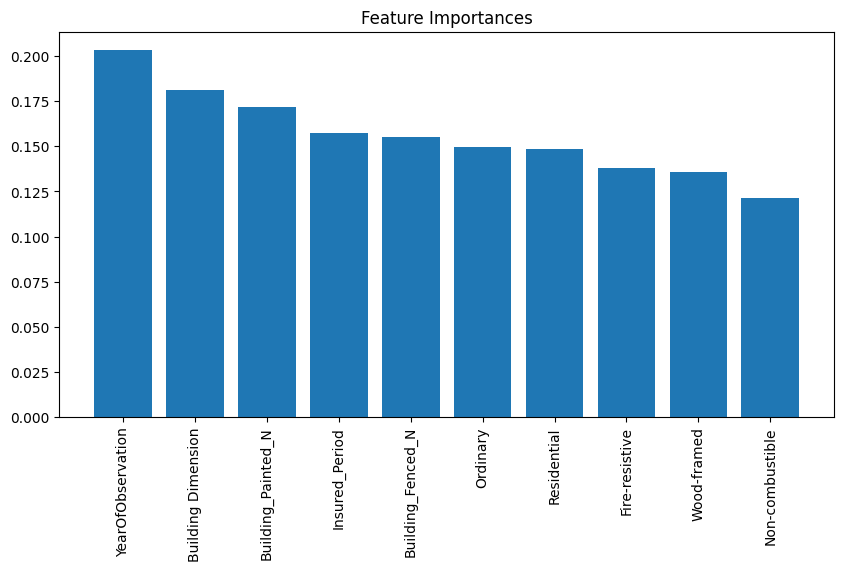

In [2233]:
# Visualisation de MLPClassifier
importances = np.mean(np.abs(mlp.coefs_[0]), axis=1)
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 5))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.show()

In [2234]:
# Scores de MLPClassifier
scores(mlp, X_train, y_train, X_test, y_test)

Train Accuracy: 0.8
Test Accuracy: 0.77
F1 Train Score: 0.77
F1 Test Score: 0.73


In [2235]:
# Fonction pour comparer les modèles avec visualisation des scores
def compare_models(models, X_train, y_train, X_test, y_test):
    results = []
    for model in models:
        model_name = model.__class__.__name__
        model.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)

        train_accuracy = accuracy_score(y_train, y_pred_train)
        test_accuracy = accuracy_score(y_test, y_pred_test)

        train_f1 = f1_score(y_train, y_pred_train, average='weighted')
        test_f1 = f1_score(y_test, y_pred_test, average='weighted')

        results.append([model_name, train_accuracy, test_accuracy, train_f1, test_f1])

    results_df = pd.DataFrame(results, columns=["Model", "Train Accuracy", "Test Accuracy", "Train F1", "Test F1"])
    return results_df

In [2236]:
models = [dtc, rfc, svc, gbc, mlp]
compare_models(models, X_train, y_train, X_test, y_test)

,Model,Train Accuracy,Test Accuracy,Train F1,Test F1
0,DecisionTreeClassifier,0.823025,0.755473,0.792781,0.715543
1,RandomForestClassifier,0.829808,0.764788,0.798809,0.709614
2,SVC,0.775339,0.763391,0.677224,0.660960
3,GradientBoostingClassifier,0.931165,0.734979,0.928660,0.706866
4,MLPClassifier,0.802474,0.768048,0.770477,0.728373
